# **Machine Learning Assignment** 
***
> Submitted by: &emsp;**Aw Chong Kiang (22034803)** <br>
Date: &emsp;&emsp;&emsp;&emsp;&ensp;**19 Jun 2022**

## Objective: Classify age of abalone from physical measurements
<img src="https://archive.ics.uci.edu/ml/assets/MLimages/Large1.jpg" width="200" height="200">
Reference: Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

## Introduction

We will be using the [Abalone Data Set](https://archive.ics.uci.edu/ml/datasets/Abalone) from UCI Machine Learning Repository:

1. Target of classification will be Age of abalones, which is determined by the number of rings counted by cutting the shell through the cone of the abalone and staining it. Age in years of abalones is given by: `Age (in years) = Number of Rings + 1.5`

2. 7 out of 8 attributes in the data set are considered suitable features:
    - Sex (Removed as gender is not likely to be effective in age classification)
    - Length
    - Diameter
    - Height
    - Whole weight (whole abalone)
    - Shucked weight (Weight of meat)
    - Viscera weight (gut weight i.e. after bleeding)
    - Shell weight (after being dried)

4. Data has been pre-processed for this data set:
    - Examples with missing values were removed as majority having missing predicted values.
    - Ranges of continuous values have been scaled for use with Artificial Neural Network (by dividing by 200).

## Classification Approach
1. Age will be categorized into 5 classes. 
2. Same training set and test set will be used. Training set and test set are normalized (i.e. subtract by mean and divided by standard deviation) separately to avoid [data leak](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html).
3. Classification will be performed using following 5 algorithims:
    - Logistic Regression
    - Decision Tree
    - Random Forest
    - Support Vector Machine
    - Naive Bayes
4. Performance of each algorithm will be accessed by F1-Score, Precision, Recall and AUC. 

## Load Data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 'abalone.csv' file stored in 'data' sub-folder
data_path = ['data']
filepath = os.sep.join(data_path + ['abalone.csv'])

# Create data frame (no header)
data = pd.read_csv(filepath, sep=',', header=None)

# Assign column heading
data.columns = [
    'Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 
    'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings'
]

## Data Exploration

In [2]:
# Define function to plot column as bar chart

def plot_column(col, wd=15, ht=5):
    fig = plt.figure(figsize=(wd, ht))
    ax = fig.gca()
    
    x = data[col].value_counts().index
    y = data[col].value_counts().values
    plt.bar(x, y)

    ax.set_title('Number of Abalones by ' + col) 
    ax.set_xlabel(col) 
    ax.set_ylabel('Number of Abalones')

#### Number of rows and columns

In [3]:
# Number of rows and columns
print("Number of Rows: %10d" %(data.shape[0]))
print("Number of Columns: %4d" %(data.shape[1]))

Number of Rows:       4177
Number of Columns:    9


#### Data types in each column

In [4]:
# data types for each columns
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB
None


#### Categorical and Target Column

Counts of unique values for 'Sex' column
--------------------------------------------------------------------------------
M    1528
I    1342
F    1307
Name: Sex, dtype: int64


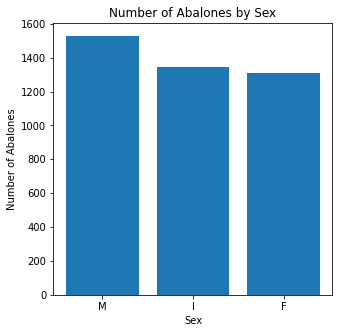

In [5]:
# Check unique values for categorical features (i.e. ignore 'Rings')
# Note that only 'Sex' is categorical feature.

print("Counts of unique values for 'Sex' column")
print("-" * 80)
print(data['Sex'].value_counts())

# Plot 'Sex' column
plot_column('Sex', 5, 5)

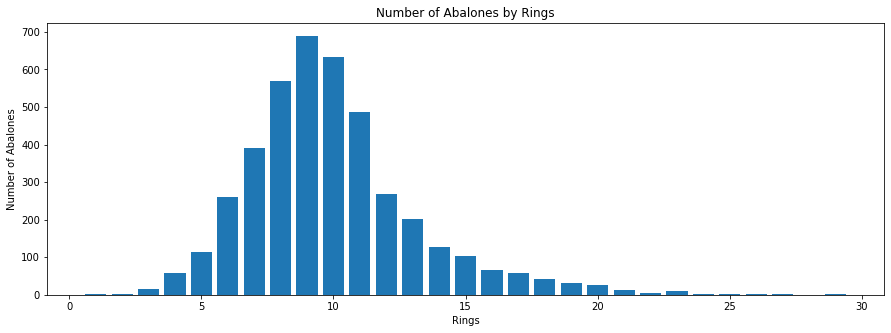

In [6]:
# Plot 'Rings' column
plot_column('Rings')

#### Statistics of Data Set

In [7]:
print(data.describe())

            Length     Diameter       Height  Whole_weight  Shucked_weight  \
count  4177.000000  4177.000000  4177.000000   4177.000000     4177.000000   
mean      0.523992     0.407881     0.139516      0.828742        0.359367   
std       0.120093     0.099240     0.041827      0.490389        0.221963   
min       0.075000     0.055000     0.000000      0.002000        0.001000   
25%       0.450000     0.350000     0.115000      0.441500        0.186000   
50%       0.545000     0.425000     0.140000      0.799500        0.336000   
75%       0.615000     0.480000     0.165000      1.153000        0.502000   
max       0.815000     0.650000     1.130000      2.825500        1.488000   

       Viscera_weight  Shell_weight        Rings  
count     4177.000000   4177.000000  4177.000000  
mean         0.180594      0.238831     9.933684  
std          0.109614      0.139203     3.224169  
min          0.000500      0.001500     1.000000  
25%          0.093500      0.130000     8.

#### Boxplot Analysis

<AxesSubplot:>

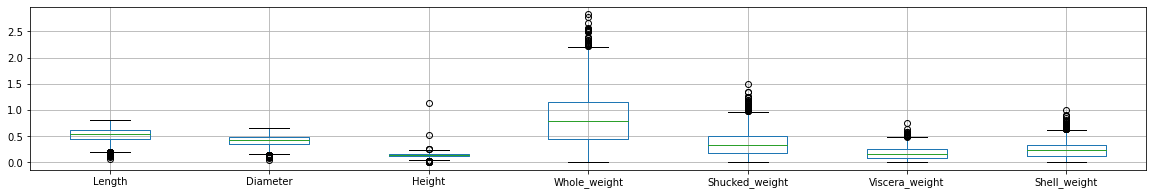

In [8]:
# Drop Target and categorical columns (i.e. 'Rings' and 'Sex') keeping only numerical columns
data_num = data.drop(['Rings','Sex'], axis=1)

# Box Plot to explore for outliers in only numerical features column (i.e. exclude 'Sex')
%matplotlib inline

data_num.boxplot(figsize=(20,3))

In [9]:
# Calculate correlation among numerical feature
data_corr = data_num.corr()
feature_col = data_num.columns

# Iterate through upper triangle to obtain cross-correlation pairs
corr_list = [[feature_col[i], feature_col[j], data_corr.iloc[i, j]]
             for i in range(len(feature_col)) for j in range(i+1, len(feature_col))]

# Create correlation data frame
df_corr = pd.DataFrame(corr_list, columns=['feature1','feature2','correlation'])

# Sort correlation by descending order
df_corr.sort_values(by='correlation', ascending=False)

,feature1,feature2,correlation
0,Length,Diameter,0.986812
15,Whole_weight,Shucked_weight,0.969405
16,Whole_weight,Viscera_weight,0.966375
17,Whole_weight,Shell_weight,0.955355
18,Shucked_weight,Viscera_weight,0.931961
7,Diameter,Whole_weight,0.925452
2,Length,Whole_weight,0.925261
20,Viscera_weight,Shell_weight,0.907656
10,Diameter,Shell_weight,0.905330
4,Length,Viscera_weight,0.903018


#### Observations
- Total of 4177 records (i.e. rows) and 8 features.
- All columns are float type except for 'Sex' ('Object' type) and 'Rings ('Int64' type). Any erroneous data/ outliers can be removed via scaling.
- The only categorical feature (i.e. 'Sex') is evenly balanced (i.e. data set is rather evenly balanced across male, female and infant)
- Range of values for the target label 'Rings' (i.e. from 1 to 29) is relatively wide with respect to the number of data points (4177 data points). Hence, aggregation of 'Rings' column to only 5 target labels before computing the 'Age' column.
- Dataset has been scaled previously (i.e. divided by 200).
- Numerical features appears to be highly correlated, ranging between 0.775 (min) to 0.987 (max)

## Data Preparation
- Recode target label from 'Rings' to 'Age' and aggregate to 5 bins instead of initial 29 unique classes.
- No missing or duplicate values hence no requirement to drop any duplicate rows or rows containing null values.
- Drop 'Sex' column as gender is unlikely to be useful for age classification.
- Data set to be separated to test and training set prior to scaling in order to avoid data leak. Purpose of scaling is to remove outliers and possible erroneuous values.

#### Missing Values

In [10]:
# True if there are any null/missing values in the column
print(data.isna().any())

Sex               False
Length            False
Diameter          False
Height            False
Whole_weight      False
Shucked_weight    False
Viscera_weight    False
Shell_weight      False
Rings             False
dtype: bool


#### Compute Abalone's Age & Drop 'Sex' Column

In [11]:
# Create new column 'Age' by computing Age = Rings + 1.5 years
data['Age'] = data['Rings'] + 1.5

# Drop 'Rings' column and create new data frame, data1
# Drop 'Sex' column as Gender is unlikely to be effective in age classification
# New dataframe, data1 contains Age column while data contains Rings column
data1 = data.drop(['Rings','Sex'], axis=1)

# Aggregate Abalone's age into 5 bins
data1['Age'] = pd.qcut(data['Age'],5)
data1

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Age
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,"(13.5, 30.5]"
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,"(2.499, 8.5]"
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,"(8.5, 10.5]"
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,"(10.5, 11.5]"
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,"(2.499, 8.5]"
...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,"(11.5, 13.5]"
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,"(10.5, 11.5]"
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,"(8.5, 10.5]"
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,"(10.5, 11.5]"


In [12]:
# Bin size and frequency per bin sorted by index
age_bin = data1['Age'].value_counts().sort_index()
print(age_bin)

(2.499, 8.5]     839
(8.5, 10.5]     1257
(10.5, 11.5]     634
(11.5, 13.5]     754
(13.5, 30.5]     693
Name: Age, dtype: int64


#### 5 classes as target value
As per above, Class 1 has the highest frequency, which may unbalance the dataset. Note that the classes are formed by using quantile-based discretization function i.e. discretize variable into equal-sized buckets based on rank or based on sample quantiles.

#### Normalize Labels

In [13]:
# Encode target labels (i.e. 'Age') with value between 0 and 4 (5 bins)
le = LabelEncoder()
data1['Age'] = le.fit_transform(data1['Age'])

Text(0, 0.5, 'Number of Abalones')

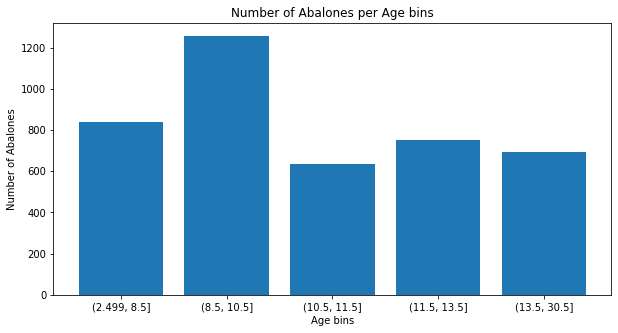

In [14]:
# plot frequency of age bins
fig = plt.figure(figsize=(10, 5))
ax = fig.gca()

x = [str(label) for label in age_bin.index]
y = [val for val in age_bin.values]

plt.bar(x, y)
ax.set_title('Number of Abalones per Age bins') 
ax.set_xlabel('Age bins') 
ax.set_ylabel('Number of Abalones')

In [15]:
for i in [0, 1, 2, 3, 4]:
    print("Label '%d' : %s" %(i, str(le.inverse_transform([i]))))

Label '0' : [Interval(2.499, 8.5, closed='right')]
Label '1' : [Interval(8.5, 10.5, closed='right')]
Label '2' : [Interval(10.5, 11.5, closed='right')]
Label '3' : [Interval(11.5, 13.5, closed='right')]
Label '4' : [Interval(13.5, 30.5, closed='right')]


#### Duplicates

In [16]:
# Sum of all duplicated rows (if any)
print(f"Number of duplicated rows in data set : {data1.duplicated().sum()}")
data1

Number of duplicated rows in data set : 0


,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Age
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,4
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,1
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,2
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,0
...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,3
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,2
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,1
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,2


#### Outliers
- Scaling (subtract mean & divide by standard deviation) may remove possible outliers (i.e. more than 3 standard deviations away from mean).

In [17]:
# Normalize feature columns i.e. exclude target labels
Z = pd.DataFrame(scale(data1[feature_col]), columns=feature_col)

# Create a list of row index whereby -3 <= Z <= 3 for the entire row
non_outlier_index = [i for i in range(Z.shape[0]) if (Z.iloc[i, :]>=-3).sum() == 7 & (Z.iloc[i, :]<=3).sum() == 7]

# Remove outliers (-3 <= Z <=3) in dataset
# New data frame, data2 contain non-outlers
data2 = data1.iloc[non_outlier_index, :]
data2

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Age
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,4
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,1
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,2
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,0
...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,3
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,2
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,1
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,2


In [18]:
print(f"Number of rows in before removing outliers     : {data1.shape[0]}")
print(f"Number of rows in after removing outliers      : {data2.shape[0]}")
print()
print(f"Number of outliers removed : {data1.shape[0] - data2.shape[0]}")

Number of rows in before removing outliers     : 4177
Number of rows in after removing outliers      : 4084

Number of outliers removed : 93


In [19]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data2[feature_col], data2['Age'], test_size=0.2, random_state=42)

print(f"Shape of training set, X_train   : {X_train.shape}")
print(f"Shape of training label, y_train : {y_train.shape}")
print(f"Shape of test set, X_test        : {X_test.shape}")
print(f"Shape of test label, y_test      : {y_test.shape}")

Shape of training set, X_train   : (3267, 7)
Shape of training label, y_train : (3267,)
Shape of test set, X_test        : (817, 7)
Shape of test label, y_test      : (817,)


In [20]:
# Standard Scaling X_train and X_test
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


Copies of X_train_upd, X_test_upd, y_train_upd and y_test will be made prior to classification in order to ensure that all algorithms are using the same test and train data for classification.

## Performance Metrics
- Define function perf_metrics to calculate precision, recall, f1 score and AUC.
- Store results in a data frame 'metrics'

In [21]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

def perf_metrics(y_test, y_pred, model, averaging='weighted', class_no=4):
    
    # Binarize label in order to compute AUC
    binary_classes = list(range(class_no))
    y_test_b = label_binarize(y_test, classes=binary_classes)
    y_pred_b = label_binarize(y_test, classes=binary_classes)
    
    # Compute precision, recall, f-score computed from precision_recall_fscore_support
    precision, recall, f_score, support = score(y_test, y_pred, average=averaging)
    
    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Binarize label prior to computing AUC
    auc = roc_auc_score(y_test_b, y_pred_b, average=averaging)
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_cm(cm, model)
    
    # Return metric
    return pd.Series({'precision':precision, 'recall':recall, 'f_score':f_score,
                                  'accuracy':accuracy, 'auc':auc}, name=model)


In [22]:
def plot_cm(cm, model):
    fig = plt.figure(figsize=(7,6))
    ax = fig.gca()
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='', cmap='Blues')

    ax.set_title(f'Confusion Matrix ({model})')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')

## Logistic Regression

precision    0.451824
recall       0.522644
f_score      0.480339
accuracy     0.522644
auc          1.000000
Name: Logistic Regression, dtype: float64 



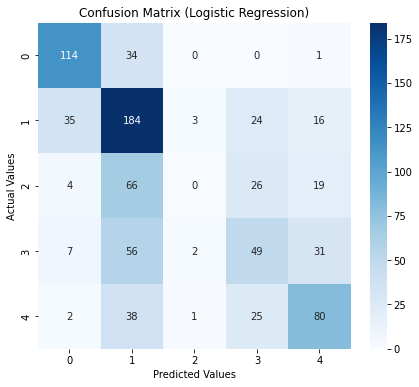

In [23]:
from sklearn.linear_model import LogisticRegression

# Use Logistic Regression with solver 'saga' and l1 penalty
LR = LogisticRegression(solver='saga', penalty='l2', random_state=42)
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)

LR_metric = perf_metrics(y_test, y_pred, "Logistic Regression")
print(LR_metric, '\n')

## Decision Tree

precision    0.404218
recall       0.402693
f_score      0.402717
accuracy     0.402693
auc          1.000000
Name: Decision Tree, dtype: float64 



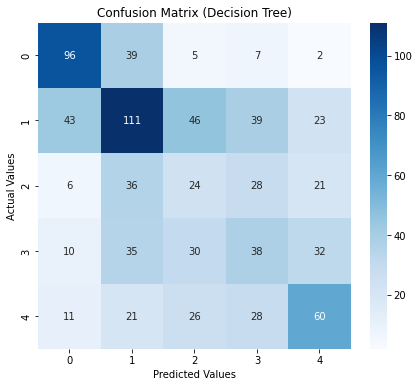

In [24]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

DT_metric = perf_metrics(y_test, y_pred, 'Decision Tree')
print(DT_metric, '\n')

## Random Forest Classifer

precision    0.404218
recall       0.402693
f_score      0.402717
accuracy     0.402693
auc          1.000000
Name: Random Tree, dtype: float64 



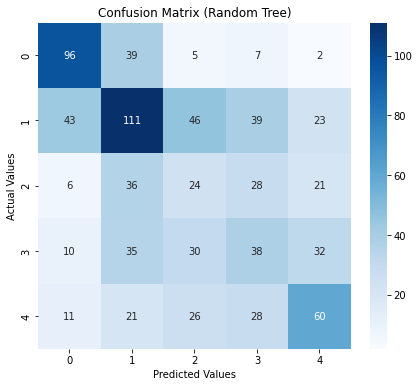

In [25]:
from sklearn.ensemble import RandomForestClassifier

# Set random seed to be similar for all classifier
np.random.seed(42)

rf_clf = RandomForestClassifier(n_estimators=5)
rf_clf.fit(X_train, y_train)

RF_metric = perf_metrics(y_test, y_pred, 'Random Tree')
print(RF_metric, '\n')

## Support Vector Machine

precision    0.439879
recall       0.514076
f_score      0.469878
accuracy     0.514076
auc          1.000000
Name: SVM, dtype: float64 



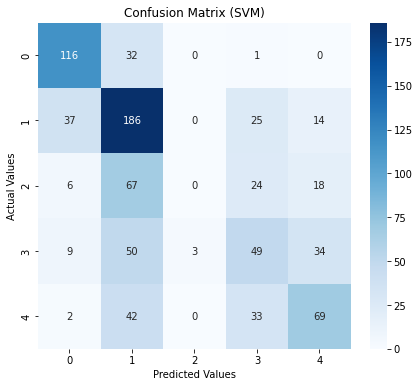

In [26]:
from sklearn import svm

# Set random seed to be similar for all classifier
np.random.seed(42)

svm_mod = svm.SVC()
svm_mod.fit(X_train, y_train)
y_pred = svm_mod.predict(X_test)

SVM_metric = perf_metrics(y_test, y_pred, 'SVM')
print(SVM_metric, '\n')

## Naive Bayes

precision    0.371350
recall       0.439412
f_score      0.397785
accuracy     0.439412
auc          1.000000
Name: Naive Bayes, dtype: float64 



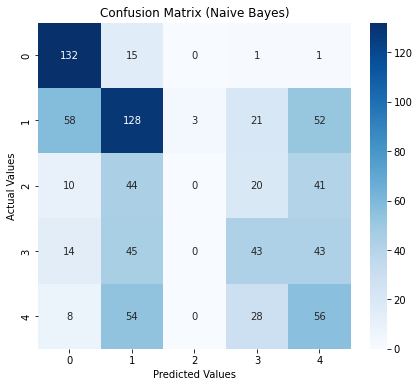

In [27]:
from sklearn.naive_bayes import GaussianNB

# Set random seed to be similar for all classifier
np.random.seed(42)

NB_mod = GaussianNB()
NB_mod.fit(X_train, y_train)
y_pred = NB_mod.predict(X_test)

NB_metric = perf_metrics(y_test, y_pred, 'Naive Bayes')
print(NB_metric, '\n')

## Summary

In [28]:
# Combine all results into a data frame.
metric_summary = pd.concat([LR_metric, DT_metric, RF_metric, SVM_metric, NB_metric], axis=1)
metric_summary

,Logistic Regression,Decision Tree,Random Tree,SVM,Naive Bayes
precision,0.451824,0.404218,0.404218,0.439879,0.371350
recall,0.522644,0.402693,0.402693,0.514076,0.439412
f_score,0.480339,0.402717,0.402717,0.469878,0.397785
accuracy,0.522644,0.402693,0.402693,0.514076,0.439412
auc,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
for row in metric_summary.index:
    model = metric_summary.loc[row].idxmax()
    max_value = metric_summary.loc[row].max()
    
    print(f"{model} has highest {row} of {max_value}")


Logistic Regression has highest precision of 0.4518242506682286
Logistic Regression has highest recall of 0.5226438188494492
Logistic Regression has highest f_score of 0.4803390060659115
Logistic Regression has highest accuracy of 0.5226438188494492
Logistic Regression has highest auc of 1.0


## Conclusion
1. As per table above, results have been disappointing:
    - F1 score is below 0.5 for all algorithms
    - Accuracy is around 0.5, which is no different from random guessing
    - AUC (Area Under Curve) is likely to be inaccurate given the poor F1 score and Accuracy
    - Training results for decision trees and random tree classifier are identical.
    - Logistic Regression has the highest precision, recall, f-score and accuracy among the 5 algorithm tested.
2. This conclusion is inline with past experiment conducted by David Clark, Zoltan Schreter, Anthony Adams "A Quantitative Comparison of Dystal and Backprogpagation"
    - Highest test performance result is 64%  based on 3133 training and 1044 testing.
3. No further hypertuning are conducted since classification models seem to be inappropriate 
4. Possible solution:
    - Reduce the number of classes to only 2 i.e. binary conditions e.g. More than 10 years old versus less than equal to 10 years old.
    - Double number of iterations from standard 100 to 200 as logistic regression didn't manage to converge by the 100th iterations.
    - Employ more advanced machine learning algorithms (like XGBoost) assuming that there are some relationship between physical measurements with age of abalone.